<a href="https://colab.research.google.com/github/jvataidee/MachineLearning/blob/master/Diagnostico_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_6ecb6c85550043f090237e5943d2647c~mv2.png/v1/fill/w_417,h_88,al_c,q_85,usm_0.66_1.00_0.01/Ativo%2023-8.webp" height="75px"></p>


#Diagnóstico de COVID-19 com imagens de Raio - X

O novo coronavírus (SARS-COV-2) tornou-se o problema mais premente enfrentado pela humanidade.  Uma alta taxa de reprodução e uma maior chance de complicações levaram ao fechamento de fronteiras, ruas vazias, estocagem desenfreada, políticas de isolamento, uma recessão econômica e uma mudança cultural em direção à desconfiança. O mundo entrou em uma nova Guerra Mundial contra um inimigo invisível.

Com o número de casos acelerando em todo o mundo, os governos estão lentamente despertando para a escala do problema, e esperaríamos ver o mundo unido contra essa ameaça. No entanto, em nível nacional e individual, ainda estamos observando divisões e desconfiança.


Neste projeto abordadomos, adaptado da prática do curso [IA Expert, do Jones Granatyr](https://iaexpert.com.br/index.php/courses/machine-learning-competicoes-kaggle-covid19-coronavirus/), foi recolhido o [*dataset*](https://github.com/ieee8023/covid-chestxray-dataset), combinando o conjunto de dados de raios-X do tórax Kaggle com o conjunto de dados de raios-X do tórax COVID19 coletados pelo [Dr.
Joseph Paul Cohen](https://josephpcohen.com/w/wp-content/uploads/2020-02-Generalization-challenges-and-making-models-right-for-the-right-reasons-in-medicine.pdf), da Universidade de Montreal. Tais dados foram coletados do repositório no dia 02 de Junho de 2020,  não possuindo caracteristicas clinicas, pois este não passou por um estudo mais elaborado. 

O conjunto de dados é dividido em 4 categorias diferentes,
com 9 imagens por classe usadas como conjunto de teste, sendo esta base dividida em:

- Saudável: 79 imagens
- Pneumonia (Viral): 79 imagens
- Pneumonia (bacteriana): 79 imagens
- Pneumonia (COVID-19): 69 imagens

Imagens esta como as figuras mostradas abaixo.

</br>
<p align="center"><img src="https://miro.medium.com/max/1400/1*a-WIZmtG7Q0PdQO0WNmjIQ.png" height="200px"></p>
<p></p>
<p align="center">Radiografia de tórax em pacientes internados. Da esquerda para a direita: saudável, bacteriana, viral, COVID19.



##Importação das bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt

# configurar a visualização
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Carregando Base de Dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = "/content/drive/My Drive/covid_dataset.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

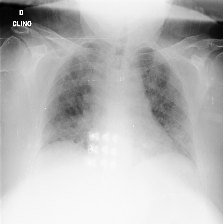

In [ ]:
#Exemplo de imagem com COVID-19
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/train/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg', target_size=(224,224))
image

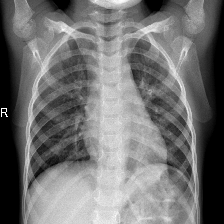

In [ ]:
#Exemplo de imagens sem doença
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/train/normal/NORMAL2-IM-1281-0001.jpeg', target_size=(224,224))
image

As imagens do dataset, são do formato JPG, desta forma foi necessário realizar as mudanças dos formatos, variando cada uma em sua rotação, zoom e rotações verticais e horizontal.

In [ ]:
#Colocando no formato necessário para o tensorFlow
train_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/covid_dataset/train',
                                                    target_size = (224, 224),
                                                    batch_size=16,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 130 images belonging to 2 classes.


A partir desta etapa, foi então identificado para a base de treino 130 imagens, pertencentes a duas classes.

In [ ]:
train_generator.n

130

In [ ]:
train_generator.batch_size

16

In [ ]:
#Dividindo base de treino
base_train = train_generator.n // train_generator.batch_size
base_train

8

In [ ]:
#Dividindo base de teste, com as imagens originais
step_size_train = train_generator.n // train_generator.batch_size
step_size_train

8

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
test_generator = test_datagen.flow_from_directory('/content/covid_dataset/test',
                                                  target_size=(224,244),
                                                  batch_size=1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 18 images belonging to 2 classes.


In [ ]:
step_size_test = test_generator.n // test_generator.batch_size
step_size_test

18

Já para a base de teste 18 imagens, pertencentes as mesmas duas classes, 

## Transfer learning

O *Transfer learning* (TL) é um problema de pesquisa em *Machine Learning* (ML) que se concentra em armazenar o conhecimento adquirido do algoritimmo ao resolver um problema e desta forma, utilizar o mesmo para um problema diferente, porem com relação.Um exemplo é p o conhecimento adquirido ao aprender a reconhecer carros, pode ser aplicado ao tentar reconhecer caminhões.

Da mesma forma, iremos utilizar um  arquitetura de rede neural convulacional já treinada pelo banco de imagens *imagenet* que possuem mais de 1000 classes de objetos, usando a  **ResNet50** que utiliza esta mesma base de dados.

### Construção do modelo

In [ ]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#Recebendo a ultima camada
x = base_model.output

In [ ]:
#Retirando uma média global
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [ ]:
#Definindo as camadas densas, nas ultimas camadas
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = base_model.input, outputs = preds)

In [ ]:
#Mostrando todas as camdas da rede
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
#Congelando os pesos até a camada 174
for layer in model.layers[:175]:
  layer.trainable = False  

In [ ]:
#Treinando as camadas 175 em diante
for layer in model.layers[175:]:
  layer.trainable = True 

In [ ]:
#Atribuindo o modulo de compilação
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#executando o treinamento do modelo, com 20 epocas
history = model.fit_generator(generator=train_generator,
                              epochs=25,
                              steps_per_epoch=step_size_train,
                              validation_data = test_generator,
                              validation_steps=step_size_test)

Epoch 1/25
8/8 [==============================] - 4s 559ms/step - loss: 0.0878 - accuracy: 0.9737 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 2/25
8/8 [==============================] - 4s 489ms/step - loss: 0.0246 - accuracy: 0.9912 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 3/25
8/8 [==============================] - 4s 481ms/step - loss: 0.0253 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 4/25
8/8 [==============================] - 4s 507ms/step - loss: 0.0921 - accuracy: 0.9649 - val_loss: 0.8084 - val_accuracy: 0.8333
Epoch 5/25
8/8 [==============================] - 4s 475ms/step - loss: 0.2793 - accuracy: 0.9211 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 6/25
8/8 [==============================] - 4s 499ms/step - loss: 0.0886 - accuracy: 0.9561 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 7/25
8/8 [==============================] - 4s 493ms/step - loss: 0.0445 - accuracy: 0.9825 - val_loss: 0.0565 - val_accuracy: 1.0000
Epoch 8/25
8/8 [====

##Avaliação da Rede

In [ ]:
MEAN  = np.mean(history.history['val_accuracy'])
MEAN

0.9488888859748841

In [ ]:
RMSE = np.std(history.history['val_accuracy'])
RMSE

0.0768516296713747

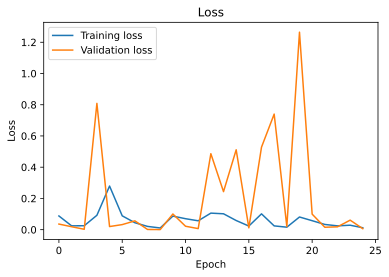

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

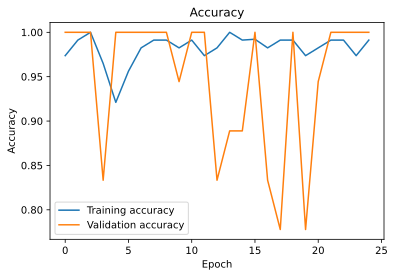

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend();

### Previsões diagnosticos

In [ ]:
filenames = test_generator.filenames
filenames

['covid/nejmoa2001191_f3-PA.jpeg',
 'covid/nejmoa2001191_f4.jpeg',
 'covid/nejmoa2001191_f5-PA.jpeg',
 'covid/radiol.2020200490.fig3.jpeg',
 'covid/ryct.2020200028.fig1a.jpeg',
 'covid/ryct.2020200034.fig2.jpeg',
 'covid/ryct.2020200034.fig5-day0.jpeg',
 'covid/ryct.2020200034.fig5-day4.jpeg',
 'covid/ryct.2020200034.fig5-day7.jpeg',
 'normal/NORMAL2-IM-1385-0001.jpeg',
 'normal/NORMAL2-IM-1396-0001.jpeg',
 'normal/NORMAL2-IM-1400-0001.jpeg',
 'normal/NORMAL2-IM-1401-0001.jpeg',
 'normal/NORMAL2-IM-1406-0001.jpeg',
 'normal/NORMAL2-IM-1412-0001.jpeg',
 'normal/NORMAL2-IM-1419-0001.jpeg',
 'normal/NORMAL2-IM-1422-0001.jpeg',
 'normal/NORMAL2-IM-1423-0001.jpeg']

In [ ]:
predictions = model.predict_generator(test_generator, steps = len(filenames))

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
predictions

array([[9.9661380e-01, 3.3862090e-03],
       [9.7595382e-01, 2.4046218e-02],
       [9.6578062e-01, 3.4219440e-02],
       [9.9975020e-01, 2.4979300e-04],
       [9.9923909e-01, 7.6097692e-04],
       [9.9991536e-01, 8.4676896e-05],
       [9.9999344e-01, 6.5459658e-06],
       [9.9998569e-01, 1.4329590e-05],
       [9.9999285e-01, 7.1388290e-06],
       [9.9224810e-05, 9.9990082e-01],
       [8.4873915e-07, 9.9999917e-01],
       [1.3428280e-04, 9.9986565e-01],
       [2.5299566e-03, 9.9747002e-01],
       [3.8810261e-02, 9.6118981e-01],
       [9.2274398e-03, 9.9077260e-01],
       [2.4571872e-07, 9.9999976e-01],
       [5.4852688e-08, 1.0000000e+00],
       [2.2642594e-06, 9.9999774e-01]], dtype=float32)

In [ ]:
predictions2 = []

for i in range(len(predictions)):
  predictions2.append(np.argmax(predictions[i]))

In [ ]:
#Matriz de confusão
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(predictions2, test_generator.classes)

1.0

In [ ]:
cm = confusion_matrix(predictions2, test_generator.classes)

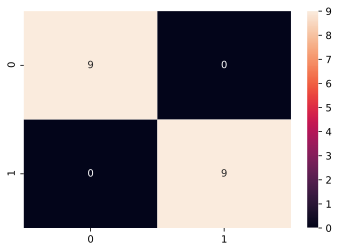

In [ ]:
sns.heatmap(cm, annot=True);

### Teste com imagem

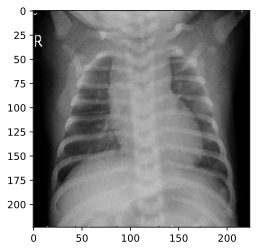

In [ ]:
#Importando as imagens
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/test/normal/NORMAL2-IM-1419-0001.jpeg', 
                                              target_size= (224,224))
plt.imshow(image);

In [ ]:
#Transformando em array
image =  tf.keras.preprocessing.image.img_to_array(image)

In [ ]:
#Transformando a imagem em array
image = np.expand_dims(image, axis = 0)

In [ ]:
image = tf.keras.applications.resnet50.preprocess_input(image)

In [ ]:
#Valores maximo e minimo dos pixels
np.max(image), np.min(image)

(151.061, -123.68)

In [ ]:
predictions = model.predict(image)
print(predictions)

[[4.5745813e-07 9.9999952e-01]]


In [ ]:
prediction = list(train_generator.class_indices)[np.argmax(predictions[0])]
prediction

'normal'

Desta forma foi possivel prever, com base no Rai-X, que este está em condições normais.